# **Decision Trees**

The Wisconsin Breast Cancer Dataset(WBCD) can be found here(https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)

This dataset describes the characteristics of the cell nuclei of various patients with and without breast cancer. The task is to classify a decision tree to predict if a patient has a benign or a malignant tumour based on these features.

Attribute Information:
```
#  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)
```


In [65]:
import pandas as pd
headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.data', na_values='?',    
         header=None, index_col=['ID'], names = headers) 
data = data.reset_index(drop=True)
data = data.fillna(0)
data.describe()

,CT,UCSize,UCShape,MA,SECSize,BN,BC,NN,Mitoses,Diagnosis
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.463519,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.640708,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


1. a) Implement a decision tree(from scratch using only python data structures) as a class.

In [66]:
class Decision_tree(object):
    def __init__(self):
        pass
    
    def fit(self,df,factor,min_splits=5,max_depth=3):
        self.factor = factor
        return self.fit_helper(df,[],min_splits,max_depth,depth=0)
        
    def is_pure(self,data):
        unique_values = np.unique(data[:,-1])
        if len(unique_values) == 1:
            return True
        else:
            return False
        
    def classified_data(self,data):
        if len(data)==0:
            return
        last_col = data[:,-1].astype(int)
        return np.bincount(last_col).argmax()
    
    def get_splits(self,data):
        splits = {}
        for index in range(len(data[0])-1):
            splits[index] = []
            temp = np.unique(data[:,index])
            for i in range(len(temp)):
                if(i!=0):
                    splits[index].append((temp[i]+temp[i-1])/2)

        return splits
    
    def entropy(self,data):
        uniqueValues, count = np.unique(data[:,-1], return_counts=True)
        p = count / count.sum()
        entropy = sum(p * -np.log2(p))

        return entropy
    
    def gini_index(self,data):
        uniqueValues, count = np.unique(data[:,-1], return_counts=True)
        p = count / count.sum()
        gini = 1-np.sum(p**2)
        
        return gini
    
    def misclassification_rate(self,data):
        uniqueValues, count = np.unique(data[:,-1], return_counts=True)
        p = count / count.sum()
        error = 1-np.max(p)
        
        return error
    
    def metric(self,data):
        if self.factor == "entropy":
            return self.entropy(data)
        elif self.factor == "gini_index":
            return self.gini_index(data)
        elif self.factor == "misclassification_rate":
            return self.misclassification_rate(data)
    
    def overall_entropy(self,yes_data,no_data):
        total = len(yes_data) + len(no_data)
        p_yes_data = len(yes_data) / total
        p_no_data = len(no_data) / total

        overall_entropy =  (p_yes_data * self.metric(yes_data) 
                          + p_no_data * self.metric(no_data))

        return overall_entropy
    
    def split_data(self,data,split_col,split_val):
        x = data[:, split_col]

        no_data = data[x <= split_val]
        yes_data = data[x >  split_val]

        return yes_data, no_data
    
    def get_split_feature(self,data,splits,cols):
        overall_entropys = 1000000
        for col in splits:
            if col not in cols:
                for val in splits[col]:
                    yes_data , no_data = self.split_data(data,col,val)
                    entropy = self.overall_entropy(yes_data,no_data)

                    if entropy < overall_entropys:
                        overall_entropys = entropy
                        split_col = col
                        split_val = val
        return split_col, split_val
    
    def fit_helper(self,df,cols,min_splits=5,max_depth=3,depth=0):
        if(depth==0):
            global col_headers
            col_headers = df.columns
            data = df.values
        else:
            data = df

        if(depth==max_depth) or len(data)<min_splits or self.is_pure(data): # is_pure
            return self.classified_data(data)
        else:
            if(len(data[0])-1) == len(cols):
                return self.classified_data(data)
            splits = self.get_splits(data) 
            split_feature, split_value = self.get_split_feature(data,splits,cols)

            data_yes, data_no = self.split_data(data,split_feature,split_value)
            cols.append(split_feature)

            data_yes = self.fit_helper(data_yes,cols,depth+1,min_splits,max_depth)
            data_no = self.fit_helper(data_no,cols,depth+1,min_splits,max_depth)

            val = str(split_feature)+" > "+str(split_value)

            if data_yes == data_no:
                return data_yes

            tree = {val:[]}
            tree[val].append(data_yes)
            tree[val].append(data_no)
        return tree
    
    def predict_helper(self,tree,test):
        key = list(tree.keys())[0]
        col = key.split(" ")[0]
        col = test[int(col)]
        question = str(col)+" > "+str(key.split(" ")[-1])
        if eval(question):
            ans = tree[key][0]
        else:
            ans = tree[key][1]

        if not isinstance(ans,dict):
            return ans

        else:
            return self.predict_helper(ans,test)
        
    def predict(self,tree,tests):
        tests = test_df.values
        predicted_values = []
        for i in range(0,len(tests)):
            temp = self.predict_helper(tree,tests[i])
            predicted_values.append(temp)
        return predicted_values

1. b) Train a decision tree object of the above class on the WBC dataset using misclassification rate, entropy and Gini as the splitting metrics.

In [67]:
def train_test_splits(df, test_size):
    if isinstance(test_size,float):
        test_size = round(test_size*len(df))
        
    indices = df.index.tolist()
    test_indices = random.sample(population=indices,k=test_size)
    
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df,test_df

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CT         699 non-null    int64  
 1   UCSize     699 non-null    int64  
 2   UCShape    699 non-null    int64  
 3   MA         699 non-null    int64  
 4   SECSize    699 non-null    int64  
 5   BN         699 non-null    float64
 6   BC         699 non-null    int64  
 7   NN         699 non-null    int64  
 8   Mitoses    699 non-null    int64  
 9   Diagnosis  699 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 54.7 KB


In [69]:
random.seed(0)
train_df, test_df = train_test_splits(data,test_size=0.2)
actual = (test_df.values[:,-1])
num_test = len(test_df)

In [70]:
obj = Decision_tree()
tree = obj.fit(train_df,"misclassification_rate")

In [71]:
pprint(tree)

predicted_vals = (obj.predict(tree,test_df))

{'2 > 3.5': [{'1 > 1.5': [{'7 > 3.5': [{'5 > 0.5': [4, 2]}, 4]}, 2]}, 2]}


In [72]:
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

MSE:  0.34285714285714286
MAE:  0.17142857142857143
r_score: 0.648699189493578
Got 128 / 140 correct => accuracy: 0.914286


1. c) Report the accuracies in each of the above splitting metrics and give the best result. 

In [73]:
print("For gini_index as metrix")
tree = obj.fit(train_df,"gini_index")
pprint(tree)
predicted_vals = (obj.predict(tree,test_df))
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy_gini = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_gini))




print("\n\n\n##############################################################\n\n")
print("For entropy as metrix")
tree = obj.fit(train_df,"entropy")
pprint(tree)
predicted_vals = (obj.predict(tree,test_df))
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy_entropy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_entropy))



print("\n\n\n##############################################################\n\n")
print("For misclassification_rate as metrix")
tree = obj.fit(train_df,"misclassification_rate")
pprint(tree)
predicted_vals = (obj.predict(tree,test_df))
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy_error = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_error))

For gini_index as metrix
{'1 > 2.5': [4, 2]}
MSE:  0.2857142857142857
MAE:  0.14285714285714285
r_score: 0.7137193107509355
Got 130 / 140 correct => accuracy: 0.928571



##############################################################


For entropy as metrix
{'1 > 2.5': [4, 2]}
MSE:  0.2857142857142857
MAE:  0.14285714285714285
r_score: 0.7137193107509355
Got 130 / 140 correct => accuracy: 0.928571



##############################################################


For misclassification_rate as metrix
{'2 > 3.5': [{'1 > 1.5': [{'7 > 3.5': [{'5 > 0.5': [4, 2]}, 4]}, 2]}, 2]}
MSE:  0.34285714285714286
MAE:  0.17142857142857143
r_score: 0.648699189493578
Got 128 / 140 correct => accuracy: 0.914286


In [74]:
accuracy_model = max(accuracy_gini,accuracy_entropy,accuracy_error)
print("accuracy of my model is : ", accuracy_model)

accuracy of my model is :  0.9285714285714286


The best accuracy is 95% with metrix as gini_index

1. d) Experiment with different approaches to decide when to terminate the tree(number of layers, purity measure, etc). Report and give explanations for all approaches. 

In [75]:
depths = [2,4,6,8,10]
minimum_splits = [5,10,15]

results = []
for d in depths:
    temp = []
    temp.append(d)
    for s in minimum_splits:
        tree = obj.fit(train_df,"gini_index",s,d)
        predicted_vals = (obj.predict(tree,test_df))
        num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
        accuracy = float(num_correct) / num_test
        temp.append(accuracy)
    results.append(temp)

In [76]:
results  = np.asarray(results)
tabulate_data = ["depths"]
for s in minimum_splits:
    tabulate_data.append("minimum_splits="+str(s))
print(tabulate(results,headers=tabulate_data))

  depths    minimum_splits=5    minimum_splits=10    minimum_splits=15
--------  ------------------  -------------------  -------------------
       2            0.928571             0.928571             0.921429
       4            0.928571             0.928571             0.921429
       6            0.928571             0.928571             0.921429
       8            0.928571             0.928571             0.921429
      10            0.935714             0.928571             0.95


With depth 10 and minimum_splits as 15 we are getting more accuracy. This indicates that for this dataset the depth and minimum_splits lie between 9-10 and 10-15 respectively.

1. e) Does standardisation and normalisation help in this case? Report

Answer:

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

The main reason for normalization for error based algorithms such as linear, logistic regression, neural networks is faster convergence to the global minimum due to the better initialization of weights.Information based algorithms (Decision Trees, Random Forests) and probability based algorithms (Naive Bayes, Bayesian Networks) don't require normalization either.

Decision trees and Random Forests are immune to the feature magnitude and hence its not required.



2. Compare your trained model with a model trained by the scikit-learn DecisionTreeClassifier module. Compare accuracies.

In [77]:
from sklearn.tree import DecisionTreeClassifier

X = data.drop('Diagnosis',axis=1)
y = data['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

display_error(y_pred,y_test)
num_correct = np.sum(y_test == y_pred)
accuracy = float(num_correct) / len(y_test)
print("accuracy is: ", accuracy)

MSE:  0.26666666666666666
MAE:  0.13333333333333333
r_score: 0.7256999554438671
accuracy is:  0.9333333333333333


In [78]:
### comparision between two models
tabular_data = [["using my model",accuracy_model],["usin inbuilt model",accuracy]]
print(tabulate(tabular_data,headers = ["","accuracy"]))

                      accuracy
------------------  ----------
using my model        0.928571
usin inbuilt model    0.933333


3. Output a depth first traversal of your decision tree in a file named ```outputimp.txt``` respectively in the following format and submit it along with the assignment.


```
<Node classification criteria in words.>
<Branch label>
  ... And so on, recursively.
```
 
For example,
a depth first search traversal for the below decision tree would be:

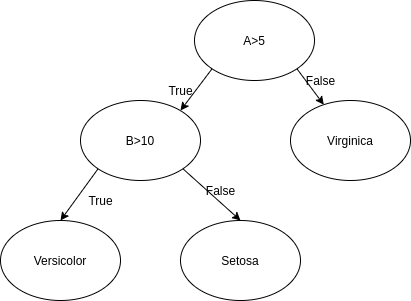
```
Is A>5?
True Branch
  Is B>10?
  True Branch
    Versicolor
  Is B>10?
  False Branch
    Setosa
Is A>5?
False Branch
	Virginica

```




In [79]:
def get_col(key):
    temp = key.split(" ")
    return cols[int(temp[0])]+ temp[1] + temp[2]

def get_result(val):
    if val == "2":
        return "benign"
    else:
        return "malignant"


def print_tree(tree,s,fp):
    print()
    key = list(tree.keys())[0]
    print(s+"Is "+str(get_col(key))+"?")
    fp.write(s+"Is "+str(get_col(key))+"?\n")
    print(s+"True Branch")
    fp.write(s+"True Branch\n")
    if isinstance(tree[key][0],dict):
        print_tree(tree[key][0],s+"   ",fp)
    else:
        fp.write(s+get_result(tree[key][0])+"\n")
        print(s+get_result(tree[key][0]))
    print()
    fp.write(s+"Is "+str(get_col(key))+"?\n")
    print(s+"Is "+str(get_col(key))+"?")
    fp.write(s+"False Branch\n")
    print(s+"False Branch")
    if isinstance(tree[key][1],dict):
        print_tree(tree[key][1],s+"   ",fp)
    else:
        fp.write(s+get_result(tree[key][1])+"\n")
        print(s+get_result(tree[key][1]))
    
cols = data.columns
fp = open("outputimp.txt","w")
print_tree(tree,"",fp)
fp.close()


Is UCSize>2.5?
True Branch

   Is BN>3.5?
   True Branch

      Is MA>5.5?
      True Branch
      malignant

      Is MA>5.5?
      False Branch

         Is CT>6.5?
         True Branch
         malignant

         Is CT>6.5?
         False Branch

            Is BC>3.5?
            True Branch
            malignant

            Is BC>3.5?
            False Branch
            malignant

   Is BN>3.5?
   False Branch

      Is SECSize>3.5?
      True Branch
      malignant

      Is SECSize>3.5?
      False Branch
      malignant

Is UCSize>2.5?
False Branch
malignant


4. Experiment with removing features that are redundant, highly correlated with other features and report accuracies of the resulting model. Explain your approach.

Index(['CT', 'UCSize', 'MA', 'SECSize', 'BN', 'BC', 'NN', 'Diagnosis'], dtype='object')


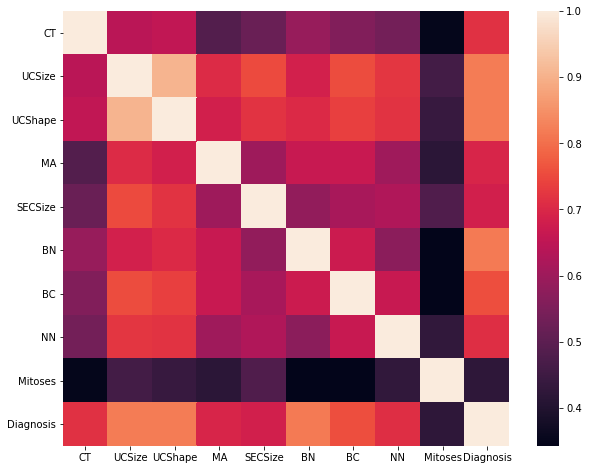

In [80]:
def plot_graph(corr):
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

corr = data.corr()
plot_graph(corr)


columns = np.full((corr.shape[0],), True, dtype=bool)


for i in range(0, corr.shape[0]):
    if(abs(corr.iloc[i,9])<0.5):
        columns[i] = False
                
selected_columns = data.columns[columns]

for i in range(0,len(selected_columns)-1):
    for j in range(i+1,len(selected_columns)-1):
        if(abs(corr[selected_columns[i]][selected_columns[j]])>0.9):
            columns[j] = False
            
selected_columns = data.columns[columns]
data1 = data[selected_columns]
print((selected_columns))

Here the column Mitosis is least correlated with the output column diagnosis. Hence that is eliminated and predicting the values only with the selected columns below.

In [81]:
random.seed(0)
train_df, test_df = train_test_splits(data1,test_size=0.2)

In [82]:
print("For gini_index as metrix")
tree = obj.fit(train_df,"gini_index")
pprint(tree)
predicted_vals = (obj.predict(tree,test_df))
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
print("\n\n\n##############################################################\n\n")
print("For entropy as metrix")
tree = obj.fit(train_df,"entropy")
pprint(tree)
predicted_vals = (obj.predict(tree,test_df))
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
print("\n\n\n##############################################################\n\n")
print("For misclassification_rate as metrix")
tree = obj.fit(train_df,"misclassification_rate")
pprint(tree)
predicted_vals = (obj.predict(tree,test_df))
display_error(predicted_vals,test_df.values[:,-1])
num_correct = np.sum(test_df.values[:,-1] == predicted_vals)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

For gini_index as metrix
{'1 > 2.5': [4, 2]}
MSE:  0.2857142857142857
MAE:  0.14285714285714285
r_score: 0.7137193107509355
Got 130 / 140 correct => accuracy: 0.928571



##############################################################


For entropy as metrix
{'1 > 2.5': [4, 2]}
MSE:  0.2857142857142857
MAE:  0.14285714285714285
r_score: 0.7137193107509355
Got 130 / 140 correct => accuracy: 0.928571



##############################################################


For misclassification_rate as metrix
{'1 > 3.5': [{'0 > 3.5': [{'2 > 3.5': [{'4 > 0.5': [4, 2]}, 4]}, 4]}, 2]}
MSE:  0.2571428571428571
MAE:  0.12857142857142856
r_score: 0.7302988706557662
Got 131 / 140 correct => accuracy: 0.935714
